This is final project for the course "Machine Learining in Graphs"

In [1]:
import pandas as pd
import networkx as nx
from consts import *
from build_graph import build_bi_partite_graph

import matplotlib.pyplot as plt
import numpy as np
from catboost import CatBoostClassifier
from matplotlib_venn import venn2
from tqdm.auto import tqdm

import data_utils
import graph_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [2]:
train_data = pd.read_csv("2021_Q1.csv")
train_data = pd.concat([train_data, pd.read_csv("2021_Q2.csv")])
train_data = pd.concat([train_data, pd.read_csv("2021_Q3.csv")])
validation_data = pd.read_csv("2021_Q4.csv")

In [3]:
print(f"Train data: {train_data.shape}")
print(f"Validation data: {validation_data.shape}")

Train data: (11038687, 3)
Validation data: (3005511, 3)


In [4]:
graph = build_bi_partite_graph(train_data, DRUG, REACTION)
print(graph)
nx.write_graphml(graph, "graph1.graphml")

validation_graph = build_bi_partite_graph(validation_data, DRUG, REACTION)


Graph with 62696 nodes and 1866087 edges


<Axes: xlabel='log(degree)', ylabel='log(Count)'>

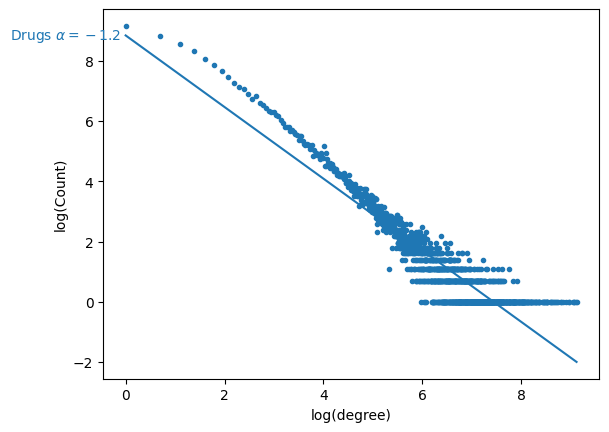

In [5]:
data_utils.plot_degree_distribiution(graph, "Drugs")

In [ ]:
edges_with_attributes = graph.edges(data=True)
sorted_edges = sorted(edges_with_attributes, key=lambda x: x[2]['weight'], reverse=True)
top_edges = sorted_edges[:500]
new_graph = nx.Graph()
new_graph.add_edges_from(top_edges)

layout = nx.spring_layout(new_graph, weight="weight")
nx.draw(new_graph, layout, node_size=30,
        with_labels=True,
        font_size=8)
nx.write_graphml(new_graph, "graph3.graphml")

In [8]:
data = []
for _ in range(10000):
    u = np.random.choice(graph.nodes)
    v = np.random.choice(graph.nodes)
    has_edge = graph.has_edge(u, v)
    jaccard_coefficient = nx.jaccard_coefficient(graph, [(u, v)])
    adamic_adar_index = nx.adamic_adar_index(graph, [(u, v)])
    preferential_attachment = nx.preferential_attachment(graph, [(u, v)])
    common_neighbors = nx.common_neighbors(graph, u, v)
    resource_allocation_index = nx.resource_allocation_index(graph, [(u, v)])
    data.append(
        {
            "u": u,
            "v": v,
            "has_edge": has_edge,
            "metric_name": "jaccard_coefficient",
            "metric_value": list(jaccard_coefficient)[0][-1],
        }
    )
    data.append(
        {
            "u": u,
            "v": v,
            "has_edge": has_edge,
            "metric_name": "adamic_adar_index",
            "metric_value": list(adamic_adar_index)[0][-1],
        }
    )
    data.append(
        {
            "u": u,
            "v": v,
            "has_edge": has_edge,
            "metric_name": "preferential_attachment",
            "metric_value": list(preferential_attachment)[0][-1],
        }
    )
    data.append(
        {
            "u": u,
            "v": v,
            "has_edge": has_edge,
            "metric_name": "common_neighbors",
            "metric_value": len(list(common_neighbors)),
        }
    )
    data.append(
        {
            "u": u,
            "v": v,
            "has_edge": has_edge,
            "metric_name": "resource_allocation_index",
            "metric_value": list(resource_allocation_index)[0][-1],
        }
    )

df_metrics = pd.DataFrame(data)
df_metrics

,u,v,has_edge,metric_name,metric_value
0,VIT 12,DICLOFENACO [DICLOFENAC SODIUM],False,jaccard_coefficient,0.0
1,VIT 12,DICLOFENACO [DICLOFENAC SODIUM],False,adamic_adar_index,0.0
2,VIT 12,DICLOFENACO [DICLOFENAC SODIUM],False,preferential_attachment,6.0
3,VIT 12,DICLOFENACO [DICLOFENAC SODIUM],False,common_neighbors,0.0
4,VIT 12,DICLOFENACO [DICLOFENAC SODIUM],False,resource_allocation_index,0.0
...,...,...,...,...,...
49995,Drug clearance increased,DIMETHICONE.,False,jaccard_coefficient,0.0
49996,Drug clearance increased,DIMETHICONE.,False,adamic_adar_index,0.0
49997,Drug clearance increased,DIMETHICONE.,False,preferential_attachment,540.0
49998,Drug clearance increased,DIMETHICONE.,False,common_neighbors,0.0


In [9]:
df_x = df_metrics.pivot_table(
    index=["u", "v"], columns="metric_name", values="metric_value"
).reset_index()
df_x

metric_name,u,v,adamic_adar_index,common_neighbors,jaccard_coefficient,preferential_attachment,resource_allocation_index
0,(ERYASPASE) L?ASPARAGINASE ENCAPSULATED IN RED...,Tobacco interaction,0.000000,0.0,0.000000,1.0,0.000000
1,0.45% NACI,BAM,0.000000,0.0,0.000000,5.0,0.000000
2,0.9% NACL,CIPRODEX,0.000000,0.0,0.000000,58.0,0.000000
3,0.9% SODIUM CHLORIDE BOLUS AND INFUSION,L?ORNITHINE,0.123417,1.0,0.034483,224.0,0.000303
4,0.9% SODIUM CHLORIDE BOLUS AND INFUSION,MELOXICAM (MELOXICAM 7.5MG TAB),0.000000,0.0,0.000000,42.0,0.000000
...,...,...,...,...,...,...,...
9995,ZYRETIC,PANALDINE,0.132256,1.0,0.045455,132.0,0.000520
9996,ZYRTEC (UNITED STATES),Transient tachypnoea of the newborn,0.000000,0.0,0.000000,1359.0,0.000000
9997,ZYRTEC?D 12HR,SULFAMETHOXAZOLE /TRIMETHOPRIM,0.000000,0.0,0.000000,8.0,0.000000
9998,[THERAPY UNSPECIFIED],TESTOSTERONE GEL,0.000000,0.0,0.000000,150.0,0.000000


In [10]:


X = df_x.drop(columns=["u", "v"])
y = np.array(
    [
        graph.has_edge(row.u, row.v)
        for _, row in df_x.iterrows()
    ]
)
weight = np.array([1 if has_edge else 0.05 for has_edge in y])
y

array([False, False, False, ..., False, False, False])

In [11]:
X_train, X_test, y_train, y_test, weight_train, weight_test = train_test_split(
    X, y, weight, test_size=0.2, random_state=42
)
# Check for data leakage
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

# Inspect the first few rows of the training data
print(X_train.head())
print(y_train[:5])


Training set size: (8000, 5)
Test set size: (2000, 5)
metric_name  adamic_adar_index  common_neighbors  jaccard_coefficient  \
9254                  3.047219              22.0             0.008352   
1561                  0.000000               0.0             0.000000   
1670                  0.000000               0.0             0.000000   
6087                  0.000000               0.0             0.000000   
6669                  0.000000               0.0             0.000000   

metric_name  preferential_attachment  resource_allocation_index  
9254                         70983.0                   0.018076  
1561                           567.0                   0.000000  
1670                             4.0                   0.000000  
6087                            36.0                   0.000000  
6669                           128.0                   0.000000  
[False False False False False]


In [12]:
%matplotlib inline
model = CatBoostClassifier(
    n_estimators=500,
    learning_rate=0.001,
    depth=12,
    eval_metric="AUC",
    loss_function="Logloss",
    l2_leaf_reg=4,
    verbose=False,
)
model.fit(
    X_train,
    y_train,
    sample_weight=weight_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=150,
    plot=True,
    verbose=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9807404	best: 0.9807404 (0)	total: 409ms	remaining: 3m 24s
1:	test: 0.9949975	best: 0.9949975 (1)	total: 685ms	remaining: 2m 50s
2:	test: 0.9959980	best: 0.9959980 (2)	total: 752ms	remaining: 2m 4s
3:	test: 0.9959980	best: 0.9959980 (2)	total: 819ms	remaining: 1m 41s
4:	test: 0.9959980	best: 0.9959980 (2)	total: 880ms	remaining: 1m 27s
5:	test: 0.9959980	best: 0.9959980 (2)	total: 943ms	remaining: 1m 17s
6:	test: 0.9959980	best: 0.9959980 (2)	total: 1.01s	remaining: 1m 10s
7:	test: 0.9959980	best: 0.9959980 (2)	total: 1.07s	remaining: 1m 5s
8:	test: 0.9959980	best: 0.9959980 (2)	total: 1.13s	remaining: 1m 1s
9:	test: 0.9959980	best: 0.9959980 (2)	total: 1.19s	remaining: 58.3s
10:	test: 0.9959980	best: 0.9959980 (2)	total: 1.25s	remaining: 55.6s
11:	test: 0.9959980	best: 0.9959980 (2)	total: 1.31s	remaining: 53.2s
12:	test: 0.9942471	best: 0.9959980 (2)	total: 1.37s	remaining: 51.2s
13:	test: 0.9942471	best: 0.9959980 (2)	total: 1.43s	remaining: 49.6s
14:	test: 0.9942471	best

<Axes: title={'center': 'Feature importance'}, ylabel='metric_name'>

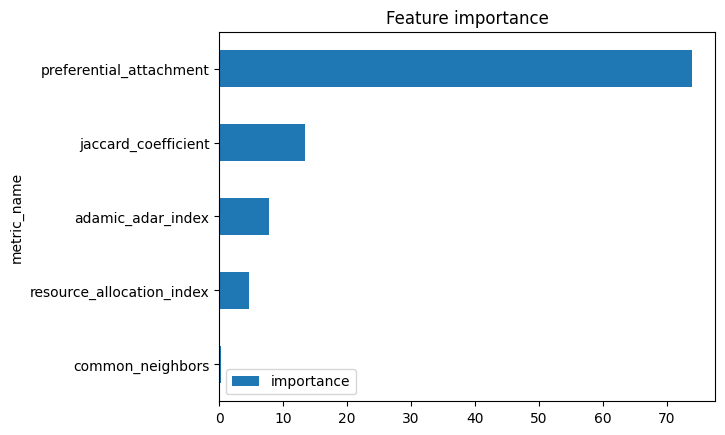

In [13]:
feature_importance = (
    pd.DataFrame(
        model.get_feature_importance(), index=X.columns, columns=["importance"]
    )
    .sort_values("importance", ascending=True)
    .tail(30)
)
feature_importance.plot(kind="barh", title="Feature importance")

The node XOLAIR has 128 new neighbors.
Reactions len: 12048


Processing reaction nodes:   0%|          | 0/12048 [00:00<?, ?it/s]

Running prediction:
Predicted: 12048


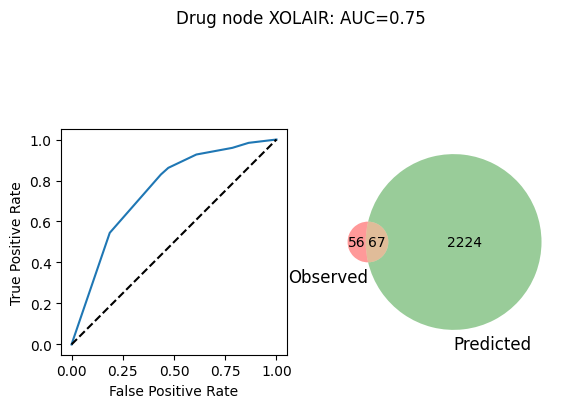

In [14]:
# new_edges = validation_graph[ (validation_graph[DRUG], validation_graph[REACTION]) not in graph.edges() ]

# Extract edges from both graphs
edges_in_graph = set(graph.edges())
edges_in_validation_graph = set(validation_graph.edges())

# Find new edges in validation_graph that are not in graph
new_edges = edges_in_validation_graph - edges_in_graph

# Convert the set of new edges to a DataFrame
new_edges = pd.DataFrame(list(new_edges), columns=[DRUG, REACTION])


def check_prediction(drug, newly_added_edges, graph_before, cutoff=0.5):
    newly_added_edges_to_drug = newly_added_edges[newly_added_edges[DRUG] == drug]
    n_added = newly_added_edges_to_drug.shape[0]
    print(f"The node {drug} has {n_added:,} new neighbors.")
    
    if not n_added:
        return
    
    to_predict_x = []
    to_predict_y = []
    
    reaction_nodes = [node for node, data in graph_before.nodes(data=True) if data['type'] == REACTION]
    print(f"Reactions len: {len(reaction_nodes)}")
    for target in tqdm(reaction_nodes, desc="Processing reaction nodes"):
        if target == drug:
            continue
        
        u, v = (target, drug)
        
        jaccard_coefficient = nx.jaccard_coefficient(graph_before, [(u, v)])
        adamic_adar_index = nx.adamic_adar_index(graph_before, [(u, v)])
        preferential_attachment = nx.preferential_attachment(graph_before, [(u, v)])
        common_neighbors = nx.common_neighbors(graph_before, u, v)
        resource_allocation_index = nx.resource_allocation_index(graph_before, [(u, v)])
        
        x_other = pd.Series({
            "adamic_adar_index": list(adamic_adar_index)[0][-1],
            "common_neighbors": len(list(common_neighbors)),
            "jaccard_coefficient": list(jaccard_coefficient)[0][-1],
            "preferential_attachment": list(preferential_attachment)[0][-1],
            "resource_allocation_index": list(resource_allocation_index)[0][-1],
        })
        
        to_predict_x.append(x_other)
        to_predict_y.append(
            newly_added_edges[
                (newly_added_edges[DRUG] == drug) & (newly_added_edges[REACTION] == target)
            ].shape[0] > 0
        )
        # print(f"Added edge: {u}, {v}")
    
    to_predict_x = pd.DataFrame(to_predict_x)
    observed = np.array(to_predict_y)
    print("Running prediction:")
    predicted_proba = model.predict_proba(to_predict_x)
    predicted = predicted_proba[:, 1] > cutoff
    print(f"Predicted: {predicted.shape[0]}")
    fpr, tpr, _ = roc_curve(y_true=observed, y_score=predicted_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    
    fig, axes = plt.subplots(ncols=2)
    
    ax = axes[0]
    ax.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
    ax.plot([0, 1], [0, 1], "k--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_aspect("equal")
    
    ax = axes[1]
    venn2(
        subsets=(set(np.where(observed)[0]), set(np.where(predicted)[0])),
        set_labels=("Observed", "Predicted"),
        ax=ax,
    )
    
    fig.suptitle(f"Drug node {drug}: AUC={roc_auc:.2f}")
    plt.show()
    
check_prediction("XOLAIR", new_edges, graph)

In [26]:
# new_edges = validation_graph[ (validation_graph[DRUG], validation_graph[REACTION]) not in graph.edges() ]

# Extract edges from both graphs
edges_in_graph = set(graph.edges())
edges_in_validation_graph = set(validation_graph.edges())

# Find new edges in validation_graph that are not in graph
new_edges = edges_in_validation_graph - edges_in_graph

# Convert the set of new edges to a DataFrame
new_edges = pd.DataFrame(list(new_edges), columns=[DRUG, REACTION])


def check_prediction(drug, newly_added_edges, graph_before, cutoff=0.5):
    newly_added_edges_to_drug = newly_added_edges[newly_added_edges[DRUG] == drug]
    n_added = newly_added_edges_to_drug.shape[0]
    print(f"The node {drug} has {n_added:,} new neighbors.")

    if not n_added:
        return

    to_predict_x = []
    to_predict_y = []

    reaction_nodes = [node for node, data in graph_before.nodes(data=True) if data['type'] == REACTION]
    print(f"Reactions len: {len(reaction_nodes)}")
    for target in tqdm(reaction_nodes, desc="Processing reaction nodes"):
        if target == drug:
            continue

        if graph_before.has_edge(target, drug):
            continue

        u, v = (target, drug)

        jaccard_coefficient = nx.jaccard_coefficient(graph_before, [(u, v)])
        adamic_adar_index = nx.adamic_adar_index(graph_before, [(u, v)])
        preferential_attachment = nx.preferential_attachment(graph_before, [(u, v)])
        common_neighbors = nx.common_neighbors(graph_before, u, v)
        resource_allocation_index = nx.resource_allocation_index(graph_before, [(u, v)])

        x_other = pd.Series({
            "adamic_adar_index": list(adamic_adar_index)[0][-1],
            "common_neighbors": len(list(common_neighbors)),
            "jaccard_coefficient": list(jaccard_coefficient)[0][-1],
            "preferential_attachment": list(preferential_attachment)[0][-1],
            "resource_allocation_index": list(resource_allocation_index)[0][-1],
        })

        to_predict_x.append(x_other)
        to_predict_y.append(
            newly_added_edges[
                (newly_added_edges[DRUG] == drug) & (newly_added_edges[REACTION] == target)
            ].shape[0] > 0
        )
        # print(f"Added edge: {u}, {v}")

    to_predict_x = pd.DataFrame(to_predict_x)
    observed = np.array(to_predict_y)
    print("Running prediction:")
    predicted_proba = model.predict_proba(to_predict_x)
    predicted = predicted_proba[:, 1] > cutoff
    print(f"Predicted: {predicted.shape[0]}")
    fpr, tpr, _ = roc_curve(y_true=observed, y_score=predicted_proba[:, 1])
    roc_auc = auc(fpr, tpr)

    fig, axes = plt.subplots(ncols=2)

    ax = axes[0]
    ax.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
    ax.plot([0, 1], [0, 1], "k--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_aspect("equal")

    ax = axes[1]
    venn2(
        subsets=(set(np.where(observed)[0]), set(np.where(predicted)[0])),
        set_labels=("Observed", "Predicted"),
        ax=ax,
    )

    fig.suptitle(f"Drug node {drug}: AUC={roc_auc:.2f}")
    plt.show()

check_prediction("GLIMEPIRIDE", new_edges, graph)

The node GLIMEPIRIDE has 171 new neighbors.
Reactions len: 12048


Processing reaction nodes:   0%|          | 0/12048 [00:00<?, ?it/s]

NetworkXError: v is not in the graph.

In [30]:
import random
def check_prediction(drug, newly_added_edges, graph_before, cutoff=0.5):
    newly_added_edges_to_drug = newly_added_edges[newly_added_edges[DRUG] == drug]
    n_added = newly_added_edges_to_drug.shape[0]
    print(f"The node {drug} has {n_added:,} new neighbors.")

    if not n_added:
        return None

    to_predict_x = []
    to_predict_y = []

    reaction_nodes = [node for node, data in graph_before.nodes(data=True) if data['type'] == REACTION]
    print(f"Reactions len: {len(reaction_nodes)}")
    for target in tqdm(reaction_nodes, desc="Processing reaction nodes"):
        if target == drug:
            continue

        if not graph_before.has_node(target) or not graph_before.has_node(drug):
            continue

        if graph_before.has_edge(target, drug):
            continue

        u, v = (target, drug)

        jaccard_coefficient = nx.jaccard_coefficient(graph_before, [(u, v)])
        adamic_adar_index = nx.adamic_adar_index(graph_before, [(u, v)])
        preferential_attachment = nx.preferential_attachment(graph_before, [(u, v)])
        common_neighbors = nx.common_neighbors(graph_before, u, v)
        resource_allocation_index = nx.resource_allocation_index(graph_before, [(u, v)])

        x_other = pd.Series({
            "adamic_adar_index": list(adamic_adar_index)[0][-1],
            "common_neighbors": len(list(common_neighbors)),
            "jaccard_coefficient": list(jaccard_coefficient)[0][-1],
            "preferential_attachment": list(preferential_attachment)[0][-1],
            "resource_allocation_index": list(resource_allocation_index)[0][-1],
        })

        to_predict_x.append(x_other)
        to_predict_y.append(
            newly_added_edges[
                (newly_added_edges[DRUG] == drug) & (newly_added_edges[REACTION] == target)
            ].shape[0] > 0
        )

    to_predict_x = pd.DataFrame(to_predict_x)
    observed = np.array(to_predict_y)
    print("Running prediction:")
    predicted_proba = model.predict_proba(to_predict_x)
    predicted = predicted_proba[:, 1] > cutoff
    print(f"Predicted: {predicted.shape[0]}")
    fpr, tpr, _ = roc_curve(y_true=observed, y_score=predicted_proba[:, 1])
    roc_auc = auc(fpr, tpr)

    return roc_auc

# Extract unique drugs from the validation data
unique_drugs = validation_data[DRUG].unique()

# Select 1000 random unique drugs from new edges only
random_drugs = random.sample(list(unique_drugs), 1000)

# Initialize an empty list to store the results
results = []

# Loop through each drug and call the check_prediction function
for drug in random_drugs:
    print("processing drug: ", drug)
    auc_score = check_prediction(drug, new_edges, graph)
    if auc_score is not None:
        res = {"Drug": drug, "auc_score": auc_score}
        print(res)
        results.append(res)

# Convert the results to a DataFrame and print it
results_df = pd.DataFrame(results, columns=["Drug", "auc_score"])
# write to file
results_df.to_csv("results.csv")

processing drug:  CONVULEX
The node CONVULEX has 0 new neighbors.
processing drug:  HYDRALAZINE
The node HYDRALAZINE has 49 new neighbors.
Reactions len: 12048


Processing reaction nodes:   0%|          | 0/12048 [00:00<?, ?it/s]

Running prediction:
Predicted: 11193
{'Drug': 'HYDRALAZINE', 'auc_score': 0.8169158522370663}
processing drug:  QUININE SULFATE
The node QUININE SULFATE has 4 new neighbors.
Reactions len: 12048


Processing reaction nodes:   0%|          | 0/12048 [00:00<?, ?it/s]

Running prediction:


CatBoostError: Input data must have at least one feature